In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

sn.set_style('whitegrid')
%matplotlib inline

<a id='index'></a>


# Measuring the classification error in EPA

## (Weighted version)

Jump to
 - [descriptive stats](#descriptive_stats)
 - [industry and occupation distributions](#ind_occ_plots)


In [2]:
# data = pd.read_csv('./Cleaned_Panel_new.csv',index_col=0)PANEL20_flows_05
data = pd.read_stata('./PANEL20_flows_05.dta')

In [3]:
data.head()

,NENT,EDAD11,SEXO1,ECIV1,SITU11,ACT1,HORASE,HORASH,RZDIFH,ACTA1,...,ERTE,ERTEh,state,ERTE_next,ERTEh_next,flow,flow_1,missing,state_alt,flow_alt
0,5,60,female,married,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,I,NaN,NaN,,,1.0,I,
1,5,35,female,divorced,"employee, private","Assembly of machnery, electrical equipment and...",40.0,40.0,NaN,NaN,...,0.0,0.0,P,NaN,NaN,,,1.0,P,
2,5,20,male,single,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,U,NaN,NaN,,,1.0,U,
3,5,40,male,married,NaN,NaN,NaN,NaN,NaN,"Transport, storage and IT.",...,0.0,0.0,U,NaN,NaN,,,1.0,U,
4,5,40,female,married,"employee, private","Financial, insurance, real state; professional...",43.0,43.0,NaN,NaN,...,0.0,0.0,T,NaN,NaN,,,1.0,T,


In [4]:
# creating categorical data (saves space)
data['ACT1'] = data['ACT1'].astype("category")
data['OCUP1'] = data['OCUP1'].astype("category")
data['ACTA1'] = data['ACTA1'].astype("category")
data['OCUPA1'] = data['OCUPA1'].astype("category")
data['SEXO1'] = data['SEXO1'].astype("category")
data['EDUC'] = data['EDUC'].astype("category")
data['ECIV1'] = data['ECIV1'].astype("category")
data['OCUP1'] = data['OCUP1'].astype("category")

# shortening long industry names
data['ACT1'] = data['ACT1'].cat.rename_categories({'Assembly of machnery, electrical equipment and transport material. Industrial installation and repair.': 'Industrial manufacturing (machinery, electrical, install and repair)'})
data['ACTA1'] = data['ACTA1'].cat.rename_categories({'Assembly of machnery, electrical equipment and transport material. Industrial installation and repair.': 'Industrial manufacturing (machinery, electrical, install and repair)'})
data['ACT1'] = data['ACT1'].cat.rename_categories({'Extractive industries, refineries, chemistry, pharma, plastics, energy supply, gas, aircon, water supply, waste management, metallurgical industries.': 'Extractive industries, chemistry, pharma and energy'})
data['ACTA1'] = data['ACTA1'].cat.rename_categories({'Extractive industries, refineries, chemistry, pharma, plastics, energy supply, gas, aircon, water supply, waste management, metallurgical industries.' : 'Extractive industries, chemistry, pharma and energy'})

In [5]:
dates = []
for year in range(2005,2022):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[:-3]

t0 = np.min(data.CICLO.unique())
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

data['dates'] = data.CICLO.map(date_dict)

In [6]:
date_dict_reverse_ciclo['2005Q1']

130

In [21]:
date_dict_reverse_ciclo['2020Q2']

191

<a id='descriptive_stats'></a>

Back to [index](#index)

### Descriptive stats (weighted)

In [7]:
def read_table(filename,path='./rawtabs/'):
    f = open(path+filename+'.log','r')
    results_follow = 0
    t0 = 2
    var_names = []
    means = []
    stds = []
    for line in f:
        words = line.split()
        if len(words)>5 and words[0] == "Variable":
            results_follow=1
        elif len(words)>3 and results_follow==1:
            if words[1]== '|':
                var_names.append(words[0])
                means.append(float(words[3]))
                stds.append(float(words[4]))
                N = int(words[2].replace(",",""))/100
            else:
                var_names.append(words[0])
                means.append(float(words[2]))
                stds.append(float(words[3]))
                N = int(words[1].replace(",","").replace("|",""))/100
    means = np.array(means)
    stds = np.array(stds)
    df = pd.DataFrame(np.vstack((means,stds)), columns=var_names,index=['mean','std'])
    return df, N

In [17]:
def format_latex_descriptive_stats(df,colname,N_df,varname_dict):
    df.rename(columns=varname_dict,inplace=True)
    df = df.T
    name0 = df[['mean']].index[0]
    buff = pd.DataFrame(df[['mean']].loc[name0])
    buff[name0] = buff[name0].apply(lambda x: "{:.3f}".format(float(x)))
    buff[name0+' std'] =  df[['std']].loc[name0].values
    buff[name0+' std'] =  buff[name0+' std'].apply(lambda x: "("+"{:.2f}".format(float(x))+")")
    for name in df[['mean']].index[1:]:
        buff[name] = df[['mean']].loc[name]
        buff[name] = buff[name].apply(lambda x: "{:.3f}".format(float(x)))
        buff[name+' std'] = df[['std']].loc[name].values
        buff[name+' std'] = buff[name+' std'].apply(lambda x: "("+"{:.2f}".format(float(x))+")")
    for name in df[['mean']].index:
        buff.rename(columns={name+' std':''},inplace='True')
    buff['N'] = N_df
    buff['N'] = buff['N'].apply(lambda x: "{:,.0f}".format(float(x)))
    buff = buff.T
    buff.rename(columns={'mean':colname},inplace='True')
    return buff

In [13]:
varname_dict={'EDAD11': 'Age','High_School': 'High School',
              'ERTE_next': 'STWs next','PC_next': 'PC next','missing':'Missing'}

data_rec_p_erte, N_p_erte = read_table('describe_rec_STW_p')
data_rec_p_nerte, N_p_nerte = read_table('describe_rec_NoSTW_p')
data_rec_i_erte, N_i_erte = read_table('describe_rec_STW_i')
data_rec_i_nerte, N_i_nerte = read_table('describe_rec_NoSTW_i')

table = format_latex_descriptive_stats(data_rec_i_erte,'Inactive and STW',N_i_erte,varname_dict)
table['Other Inactive'] = format_latex_descriptive_stats(data_rec_i_nerte,'Other Inactive',N_i_nerte,varname_dict)
table['PC and ERTE'] = format_latex_descriptive_stats(data_rec_p_erte,'PC and STW',N_p_erte,varname_dict)
table['Other PC'] = format_latex_descriptive_stats(data_rec_p_nerte,'Other PC',N_p_nerte,varname_dict)
print(table.to_latex())

\begin{tabular}{lllll}
\toprule
{} & Inactive and STW & Other Inactive & PC and ERTE &     Other PC \\
\midrule
Age         &           46.262 &         38.611 &      42.707 &       39.145 \\
            &          (11.09) &        (16.63) &     (10.20) &      (10.54) \\
Female      &             0.21 &           0.65 &        0.17 &         0.44 \\
            &           (0.41) &         (0.48) &      (0.37) &       (0.50) \\
College     &             0.31 &           0.13 &        0.26 &         0.41 \\
            &           (0.46) &         (0.34) &      (0.44) &       (0.49) \\
High School &             0.52 &           0.56 &        0.60 &         0.49 \\
            &           (0.50) &         (0.50) &      (0.49) &       (0.50) \\
Married     &             0.71 &           0.52 &        0.68 &         0.62 \\
            &           (0.45) &         (0.50) &      (0.47) &       (0.49) \\
PC next     &             0.15 &           0.01 &        0.63 &         0.67 \\
        

In [18]:
data_cov_p_erte, N_p_erte = read_table('describe_cov_STW_p')
data_cov_p_nerte, N_p_nerte = read_table('describe_cov_NoSTW_p')
data_cov_i_erte, N_i_erte = read_table('describe_cov_STW_i')
data_cov_i_nerte, N_i_nerte = read_table('describe_cov_NoSTW_i')

table = format_latex_descriptive_stats(data_cov_i_erte,'Inactive and ERTE',N_i_erte )
table['Other Inactive'] = format_latex_descriptive_stats(data_cov_i_nerte,'Other Inactive',N_i_nerte )
table['PC and ERTE'] = format_latex_descriptive_stats(data_cov_p_erte,'PC and ERTE',N_p_erte )
table['Other PC'] = format_latex_descriptive_stats(data_cov_p_nerte,'Other PC',N_p_nerte )
print(table.to_latex())

TypeError: format_latex_descriptive_stats() missing 1 required positional argument: 'varname_dict'

In [19]:
varname_dict={'EDAD11': 'Age','High_School': 'High School',
              'ERTE_next': 'STWs next','E_next': 'Employed next','missing':'Missing'}

data_rec_e_erte, N_rec_e_erte = read_table('describe_rec_STW_e')
data_rec_e_nerte, N_rec_e_nerte = read_table('describe_rec_NoSTW_e')
data_cov_e_erte, N_cov_e_erte = read_table('describe_cov_STW_e')
data_cov_e_nerte, N_cov_e_nerte = read_table('describe_cov_NoSTW_e')

table = format_latex_descriptive_stats(data_rec_e_erte,'STW',N_rec_e_erte,varname_dict)
table['Other Employed'] = format_latex_descriptive_stats(data_rec_e_nerte,'Other Employed',N_rec_e_nerte,varname_dict)
table['STW - cov'] = format_latex_descriptive_stats(data_cov_e_erte,'STW - cov',N_cov_e_erte,varname_dict)
table['Other Employed - cov'] = format_latex_descriptive_stats(data_cov_e_nerte,'Other Employed - cov',N_cov_e_nerte,varname_dict)
print(table.to_latex())

\begin{tabular}{lllll}
\toprule
{} &      STW & Other Employed &  STW - cov & Other Employed - cov \\
\midrule
Age           &   42.188 &         39.145 &     38.370 &               42.326 \\
              &  (10.41) &        (10.54) &    (11.16) &              (10.31) \\
Female        &    0.170 &          0.441 &      0.508 &                0.465 \\
              &   (0.38) &         (0.50) &     (0.50) &               (0.50) \\
College       &    0.262 &          0.409 &      0.327 &                0.490 \\
              &   (0.44) &         (0.49) &     (0.47) &               (0.50) \\
High School   &    0.595 &          0.487 &      0.626 &                0.472 \\
              &   (0.49) &         (0.50) &     (0.48) &               (0.50) \\
Married       &    0.661 &          0.618 &      0.446 &                0.573 \\
              &   (0.47) &         (0.49) &     (0.50) &               (0.49) \\
Employed next &    0.619 &          0.673 &      0.517 &                0.608 \

<a id='ind_occ_plots'></a>

Back to [index](#index)

### Industry and occupation distributions (weighted)

In [90]:
industr_dict = dict(zip(range(10),data['ACT1'].cat.categories))
occ_dict = dict(zip(range(10),data['OCUP1'].cat.categories))

In [178]:
def read_table_ind_occ(filename,varnames,tabname,path='./rawtabs/'):
    f = open(path+filename+'.log','r')
    results_follow = 0
    t0 = 2
    var_names = []
    means = []
    for line in f:
        words = line.split()
#         print(words)
        if len(words)>0 and words[0] == '------------+-----------------------------------':
            results_follow=1
        elif len(words)>3 and words[0] == "Total":
            break
        elif len(words)>3 and results_follow==1:
            if words[1]== '|':
                var_names.append(words[0])
                means.append(float(words[3]))
            else:
                var_names.append(words[0])
                means.append(float(words[2]))
    means = np.array(means)
    if '0' not in var_names:
        df = pd.DataFrame(np.hstack((0,means)), columns=[tabname,],index=varnames)
    else:
        df = pd.DataFrame(means, columns=[tabname,],index=varnames)
    return df

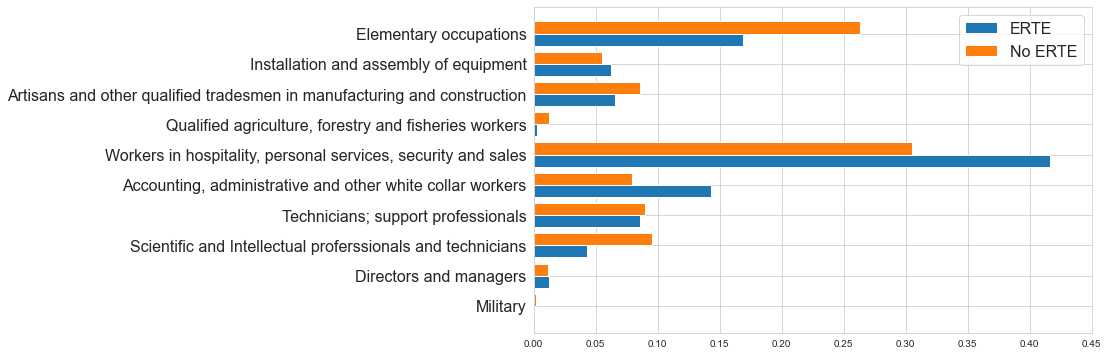

In [180]:
hdata_i_erte = read_table_ind_occ("data_cov_occ_STW_i",data['OCUP1'].cat.categories,'m')
hdata_i_nerte = read_table_ind_occ("data_cov_occ_NoSTW_i",data['OCUP1'].cat.categories,'m')
N = hdata_i_nerte.size

plt.figure(figsize=(10,6))
plt.barh(range(N),hdata_i_erte.m.values/100,height=0.4, label='ERTE')
plt.barh(np.arange(N)+0.4,hdata_i_nerte.m.values/100,height=0.4, label='No ERTE')
plt.yticks(np.arange(N)+0.2,hdata_i_erte.index,fontsize=16)
plt.xlim(0,0.45)
plt.legend(fontsize=16)
# plt.tight_layout()
plt.savefig('./plots/TWS_Spain_w_i_ocup.jpg',format='jpg',pil_kwargs={'quality':95},bbox_inches='tight')
plt.show()

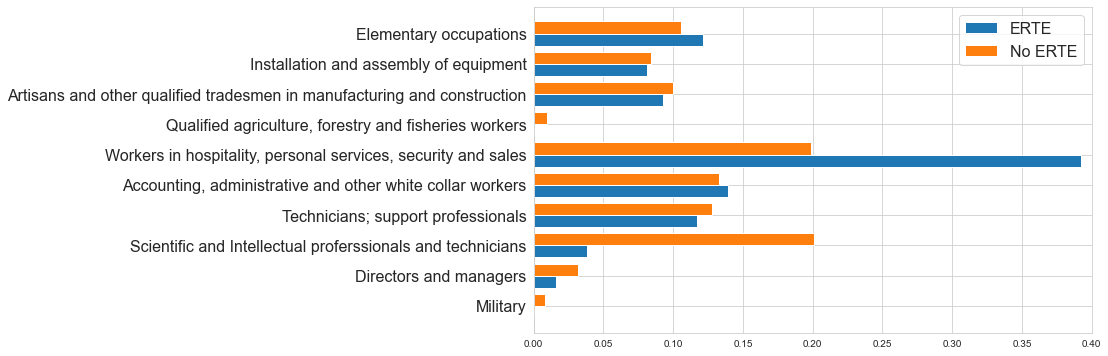

In [182]:
hdata_p_erte = read_table_ind_occ("data_cov_occ_STW_p",data['OCUP1'].cat.categories,'m')
hdata_p_nerte = read_table_ind_occ("data_cov_occ_NoSTW_p",data['OCUP1'].cat.categories,'m')
N = hdata_p_nerte.size

plt.figure(figsize=(10,6))
plt.barh(range(N),hdata_p_erte.m.values/100,height=0.4, label='ERTE')
plt.barh(np.arange(N)+0.4,hdata_p_nerte.m.values/100,height=0.4, label='No ERTE')
plt.yticks(np.arange(N)+0.2,hdata_p_nerte.index,fontsize=16)
plt.legend(fontsize=16)
plt.xlim(0,0.4)
plt.savefig('./plots/TWS_Spain_w_p_ocup.jpg',format='jpg',pil_kwargs={'quality':95},bbox_inches='tight')
plt.show()

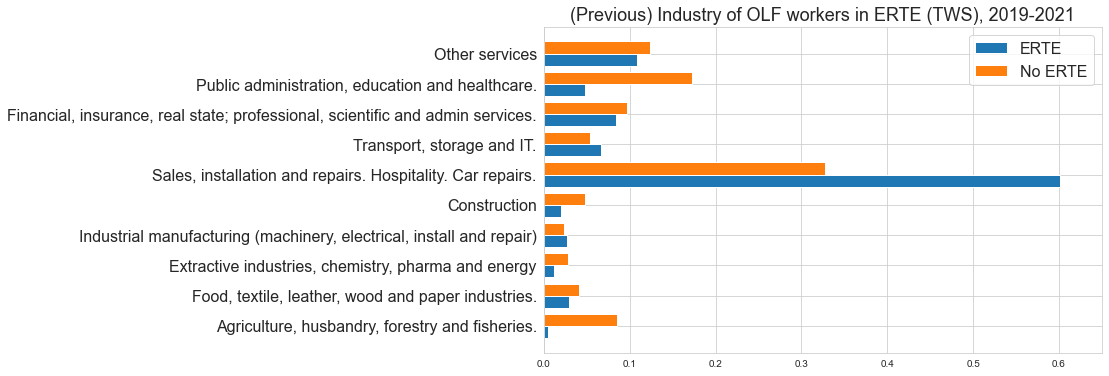

In [186]:
hdata_i_erte = read_table_ind_occ("data_cov_ind_STW_i",data['ACT1'].cat.categories,'m')
hdata_i_nerte = read_table_ind_occ("data_cov_ind_NoSTW_i",data['ACT1'].cat.categories,'m')
N = hdata_i_nerte.size

plt.figure(figsize=(10,6))
plt.title('(Previous) Industry of OLF workers in ERTE (TWS), 2019-2021',fontsize=18)
plt.barh(range(N),hdata_i_erte.m.values/100,height=0.4, label='ERTE')
plt.barh(np.arange(N)+0.4,hdata_i_nerte.m.values/100,height=0.4, label='No ERTE')
plt.yticks(np.arange(N)+0.2,hdata_i_nerte.index,fontsize=16)
plt.xlim(0,0.65)
plt.legend(fontsize=16)
plt.savefig('./plots/TWS_Spain_w_i_ind.jpg',format='jpg',pil_kwargs={'quality':95},bbox_inches='tight')
plt.show()

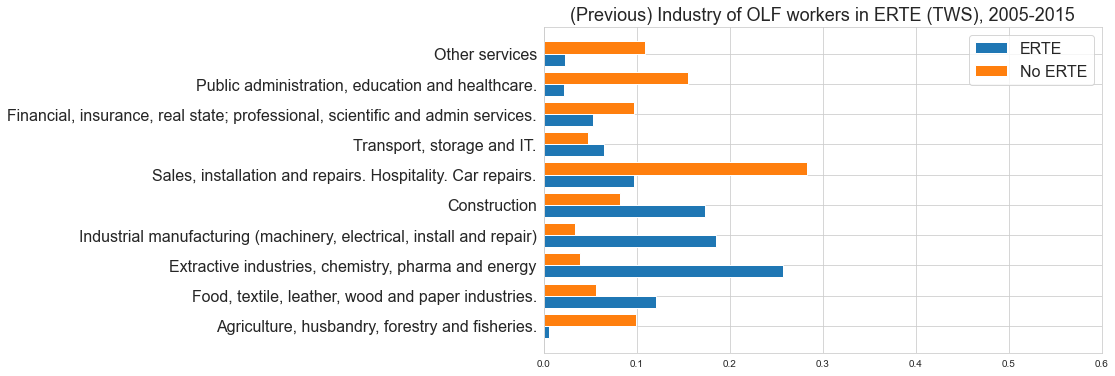

In [189]:
hdata_i_erte = read_table_ind_occ("data_rec_ind_STW_i",data['ACT1'].cat.categories,'m')
hdata_i_nerte = read_table_ind_occ("data_rec_ind_NoSTW_i",data['ACT1'].cat.categories,'m')
N = hdata_i_nerte.size

plt.figure(figsize=(10,6))
plt.title('(Previous) Industry of OLF workers in ERTE (TWS), 2005-2015',fontsize=18)
plt.barh(range(N),hdata_i_erte.m.values/100,height=0.4, label='ERTE')
plt.barh(np.arange(N)+0.4,hdata_i_nerte.m.values/100,height=0.4, label='No ERTE')
plt.yticks(np.arange(N)+0.2,hdata_i_nerte.index,fontsize=16)
plt.xlim(0,0.6)
plt.legend(fontsize=16)
plt.savefig('./plots/TWS_Spain_rec_w_i_ind.jpg',format='jpg',pil_kwargs={'quality':95},bbox_inches='tight')
plt.show()

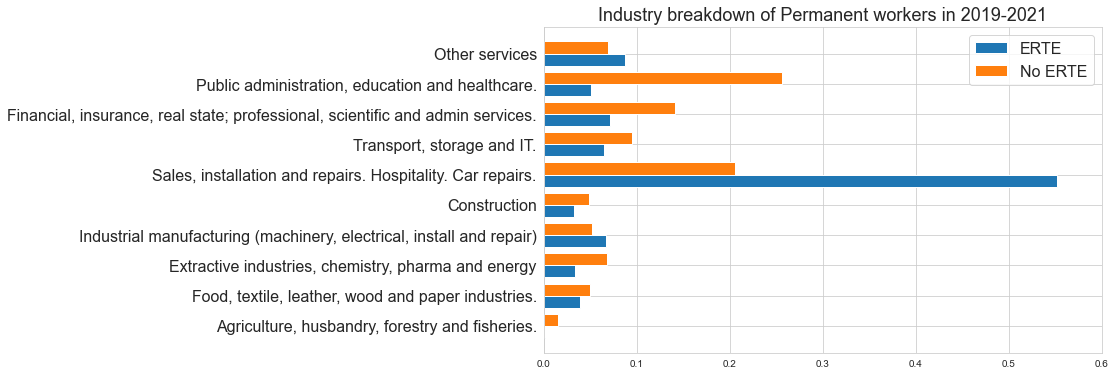

In [190]:
hdata_p_erte = read_table_ind_occ("data_cov_ind_STW_p",data['ACT1'].cat.categories,'m')
hdata_p_nerte = read_table_ind_occ("data_cov_ind_NoSTW_p",data['ACT1'].cat.categories,'m')
N = hdata_p_nerte.size

plt.figure(figsize=(10,6))
plt.title('Industry breakdown of Permanent workers in 2019-2021',fontsize=18)
plt.barh(range(N),hdata_p_erte.m.values/100,height=0.4, label='ERTE')
plt.barh(np.arange(N)+0.4,hdata_p_nerte.m.values/100,height=0.4, label='No ERTE')
plt.yticks(np.arange(N)+0.2,hdata_p_erte.index,fontsize=16)
plt.legend(fontsize=16)
plt.xlim(0,0.6)
plt.savefig('./plots/TWS_Spain_w_p_ind.jpg',format='jpg',pil_kwargs={'quality':95},bbox_inches='tight')
plt.show()

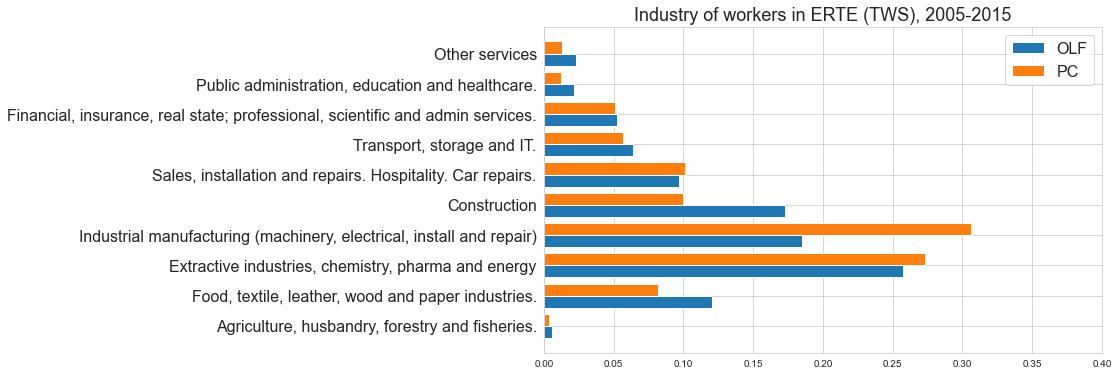

In [196]:
hdata_p_erte = read_table_ind_occ("data_rec_ind_STW_p",data['ACT1'].cat.categories,'m')
hdata_i_erte = read_table_ind_occ("data_rec_ind_STW_i",data['ACT1'].cat.categories,'m')

plt.figure(figsize=(10,6))
plt.title('Industry of workers in ERTE (TWS), 2005-2015',fontsize=18)
plt.barh(range(N),hdata_i_erte.m.values/100,height=0.4, label='OLF')
plt.barh(np.arange(N)+0.4,hdata_p_erte.m.values/100,height=0.4, label='PC')
plt.yticks(np.arange(N)+0.2,hdata_i_erte.index,fontsize=16)
plt.xlim(0,0.4)
plt.legend(fontsize=16)
plt.savefig('./plots/TWS_Spain_w_ip_rec_ind.jpg',format='jpg',pil_kwargs={'quality':95},bbox_inches='tight')
plt.show()

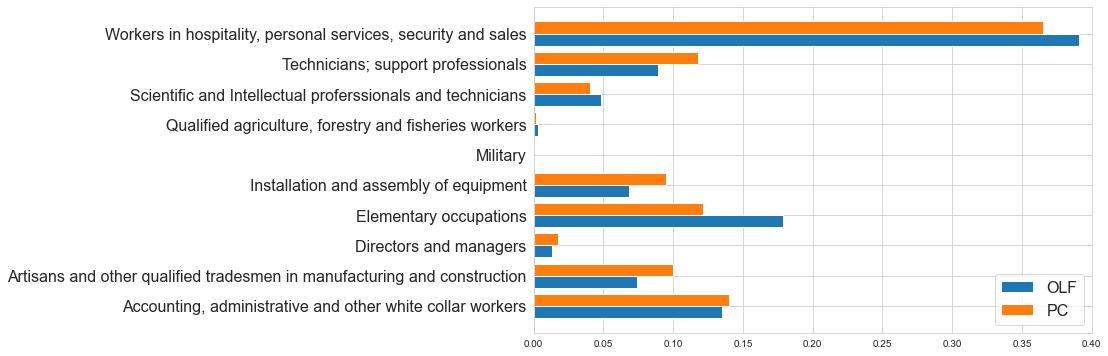

In [50]:
hdata_p_erte = read_table_ind_occ("data_cov_ind_STW_p",data['ACT1'].cat.categories,'m')
hdata_i_erte = read_table_ind_occ("data_cov_ind_STW_i",data['ACT1'].cat.categories,'m')

plt.figure(figsize=(10,6))
plt.barh(range(N),hdata_i_erte.m.values,height=0.4, label='OLF')
plt.barh(np.arange(N)+0.4,hdata_p_erte.m.values,height=0.4, label='PC')
plt.yticks(np.arange(N)+0.2,hdata_p_erte.index,fontsize=16)
plt.xlim(0,0.4)
plt.legend(fontsize=16)
plt.savefig('./plots/TWS_Spain_w_ip_ocp.jpg',format='jpg',pil_kwargs={'quality':95},bbox_inches='tight')
plt.show()

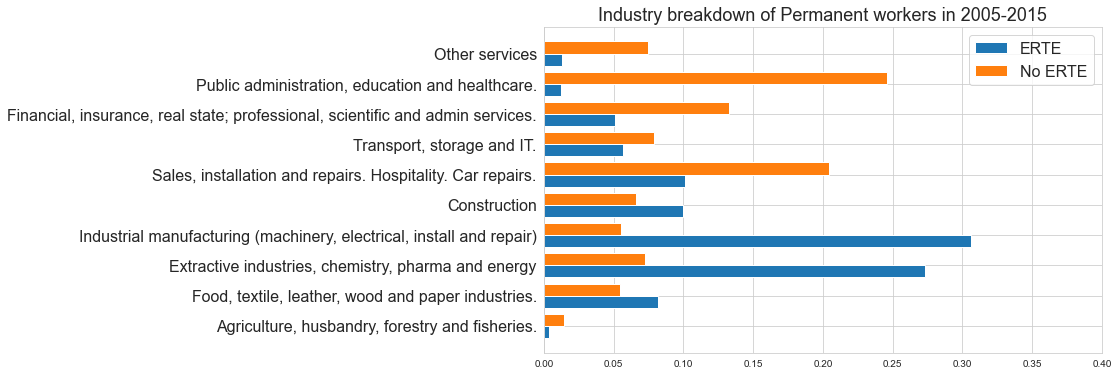

In [198]:
hdata_p_erte = read_table_ind_occ("data_rec_ind_STW_p",data['ACT1'].cat.categories,'m')
hdata_p_nerte = read_table_ind_occ("data_rec_ind_NoSTW_p",data['ACT1'].cat.categories,'m')
N = hdata_p_nerte.size

plt.figure(figsize=(10,6))
plt.title('Industry breakdown of Permanent workers in 2005-2015',fontsize=18)
plt.barh(range(N),hdata_p_erte.m.values/100,height=0.4, label='ERTE')
plt.barh(np.arange(N)+0.4,hdata_p_nerte.m.values/100,height=0.4, label='No ERTE')
plt.yticks(np.arange(N)+0.2,hdata_p_nerte.index,fontsize=16)
plt.xlim(0,0.4)
plt.legend(fontsize=16)
plt.savefig('./plots/TWS_Spain_rec_w_p_ind.jpg',format='jpg',pil_kwargs={'quality':95},bbox_inches='tight')
plt.show()

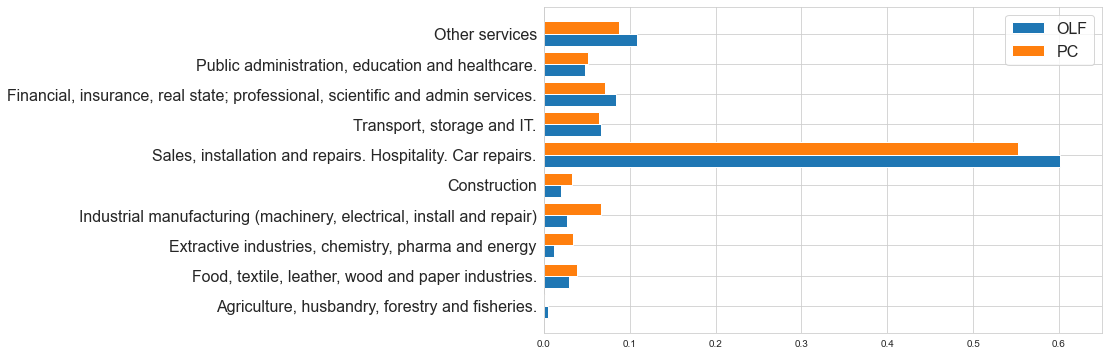

In [194]:
hdata_p_erte = read_table_ind_occ("data_cov_ind_STW_p",data['ACT1'].cat.categories,'m')
hdata_i_erte = read_table_ind_occ("data_cov_ind_STW_i",data['ACT1'].cat.categories,'m')

plt.figure(figsize=(10,6))
plt.barh(range(N),hdata_i_erte.m.values/100,height=0.4, label='OLF')
plt.barh(np.arange(N)+0.4,hdata_p_erte.m.values/100,height=0.4, label='PC')
plt.yticks(np.arange(N)+0.2,hdata_p_erte.index,fontsize=16)
plt.xlim(0,0.65)
plt.legend(fontsize=16)
plt.savefig('./plots/TWS_Spain_w_ip_ocp.jpg',format='jpg',pil_kwargs={'quality':95},bbox_inches='tight')
plt.show()